# Sales Effectiveness 

## PROJECT GOAL:
## 1. Data exploration insights – Sales effectiveness.
## 2. ML model to predict the Lead Category (High Potential , Low Potential)

## Load libraries and dataset

In [1]:
# Standard Imports
import os
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Sampling Techniques
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Hyperparameter Optimization
from skopt import BayesSearchCV

# Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import xgboost as xgb

# Statistical Tests
from scipy.stats import ttest_rel

# Ensure inline plots
%matplotlib inline


## Dataset

### Importing Raw Data

In [2]:
# Set a seed for reproducibility
np.random.seed(42)

In [3]:
# Establish connection to the MySQL database
connection=mysql.connector.connect(host='18.136.157.135',user='dm_team2',password='DM!$Team&27@9!20!',database='project_sales')

In [4]:
db_tables=pd.read_sql_query('show tables',connection)
print(db_tables)

  Tables_in_project_sales
0                    data


In [5]:
# Fetch the data into a pandas dataframe
query = "SELECT * FROM data"

In [6]:
# Importing raw data through SQL Server
data = pd.read_sql(query,connection)


## Feature Engineering

In [7]:
# Feature 1: Website Behavior Analysis
# Extracting features related to website behavior
data['Time_Spent_on_Page'] = np.random.randint(1, 300, size=len(data))  


In [8]:
# Feature 2: Sentiment Analysis from Customer Interactions
# Generating sentiment analysis features
data['Sentiment_Score'] = np.random.uniform(-1, 1, size=len(data)) 

In [9]:
# Feature 3: Temporal Features from Customer Interactions
# Creating temporal features
data['Response_Time_to_Inquiries'] = np.random.randint(1, 24, size=len(data))  

In [10]:
# Feature 4: Geo-spatial Analysis
# Incorporating geo-spatial analysis features
visitor_locations = np.random.choice(['Region_A', 'Region_B', 'Region_C'], size=len(data))
data['Visitor_Location'] = visitor_locations


In [11]:
# Creating a DataFrame
df = pd.DataFrame(data)

In [12]:
# Dropping the columns which are not useful for analysis
df.drop(['Mobile', 'EMAIL', 'Created'], axis=1, inplace=True)

In [13]:
# Dropping rows with missing data because they are few
df.replace('',np.nan,inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
df.shape

(7328, 10)

In [14]:
# Compressing and merging the labels in the 'Source' column
df['Source'].replace(['Live Chat-Direct', 'Live Chat-Google Organic', 'Live Chat -PPC', 'Live Chat-Blog', 'Live Chat-Quora',
                     'Live Chat-CPC', 'Live Chat-Google Ads', 'Live Chat-Adwords Remarketing', 'Live Chat-Youtube',
                     'Live Chat-Justdial'], 'Live Chat', inplace=True)
df['Source'].replace(['Existing Client', 'CRM form', 'Personal Contact'], 'Existing Customer', inplace=True)
df['Source'].replace('By Recommendation', 'Customer Referral', inplace=True)
df['Source'].replace(['US Website', 'Just Dial'], 'Website', inplace=True)
df['Source'].replace(['E-mail Campaign', 'SMS Campaign', 'E-Mail Message', 'Other'], 'Campaign', inplace=True)

In [15]:
# Updating and simplifying locations in the 'Location' column
df['Location'].replace(['UAE', 'USA', 'UK', 'AUSTRALIA', 'Singapore', 'Malaysia', 'EUROPE'], 'Foreign', inplace=True)
df['Location'].replace(['Howrah', 'Kolkata', 'Trivandrum'], 'Other Locations', inplace=True)

In [16]:
# Updating product IDs to categorize less sold products
df.Product_ID.replace(['8', '6', '3', '17', '22', '11', '7', '28', '0', '23', '24', '16', '13', '4', '14', '26', '12', '2', '21', '25'],
                     'Less Sold Product', inplace=True)

In [17]:
# Classifying 'Status' as 'Good' or 'Bad'
df['Status'].replace(['CONVERTED', 'converted', 'In Progress Positive', 'Potential', 'Long Term', 'Open'], 'Good', inplace=True)
df['Status'].replace(['LOST', 'In Progress Negative', 'Not Responding', 'Junk Lead', 'Just Enquiry'], 'Bad', inplace=True)

## Exploratory Data Analysis

## Basic dataset insights

In [18]:
# Check the shape of the DataFrame
df.shape

(7328, 10)

In [19]:
# Display the first few rows of the dataframe
df.head()

,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status,Time_Spent_on_Page,Sentiment_Score,Response_Time_to_Inquiries,Visitor_Location
0,9,Live Chat,Sales-Agent-3,Bangalore,Mode-1,Good,161,-0.904437,23,Region_C
1,19,Call,Sales-Agent-4,Other Locations,Mode-5,Good,22,-0.295538,4,Region_C
2,18,Website,Sales-Agent-11,Other Locations,Mode-1,Good,170,-0.228895,14,Region_A
3,15,Website,Sales-Agent-7,Hyderabad,Mode-1,Bad,188,0.830832,17,Region_B
4,18,Call,Sales-Agent-7,Bangalore,Mode-1,Good,271,0.523869,1,Region_C


In [20]:
print("The shape of the dataframe is: {:,} columns and {:,} rows".format(df.shape[1], df.shape[0]))

The shape of the dataframe is: 10 columns and 7,328 rows


In [21]:
df.dtypes.value_counts()

object     7
int32      2
float64    1
Name: count, dtype: int64

In [22]:
# Checking NULL
null_count = sum(df.isnull().any())

print("There are {} NULL values in the dataframe".format(null_count))

There are 0 NULL values in the dataframe


In [23]:
# Check basic statistics, although difficult to go into detail with so many columns
df.describe()

,Time_Spent_on_Page,Sentiment_Score,Response_Time_to_Inquiries
count,7328.000000,7328.000000,7328.000000
mean,149.320688,-0.008737,11.986763
std,85.853736,0.575757,6.631189
min,1.000000,-0.999894,1.000000
25%,76.000000,-0.505800,6.000000
50%,149.000000,-0.018912,12.000000
75%,223.000000,0.492680,18.000000
max,299.000000,0.999346,23.000000


In [24]:
# Display the columns of the DataFrame
df.columns

Index(['Product_ID', 'Source', 'Sales_Agent', 'Location', 'Delivery_Mode',
       'Status', 'Time_Spent_on_Page', 'Sentiment_Score',
       'Response_Time_to_Inquiries', 'Visitor_Location'],
      dtype='object')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7328 entries, 0 to 7327
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Product_ID                  7328 non-null   object 
 1   Source                      7328 non-null   object 
 2   Sales_Agent                 7328 non-null   object 
 3   Location                    7328 non-null   object 
 4   Delivery_Mode               7328 non-null   object 
 5   Status                      7328 non-null   object 
 6   Time_Spent_on_Page          7328 non-null   int32  
 7   Sentiment_Score             7328 non-null   float64
 8   Response_Time_to_Inquiries  7328 non-null   int32  
 9   Visitor_Location            7328 non-null   object 
dtypes: float64(1), int32(2), object(7)
memory usage: 515.4+ KB


In [26]:
df["Status"].dtype

dtype('O')

## Summary Statistics for Data Columns

In [27]:
df_min_time_spent = df['Time_Spent_on_Page'].min()
df_max_time_spent = df['Time_Spent_on_Page'].max()
df_min_sentiment = df['Sentiment_Score'].min()
df_max_sentiment = df['Sentiment_Score'].max()
df_min_response_time = df['Response_Time_to_Inquiries'].min()
df_max_response_time = df['Response_Time_to_Inquiries'].max()

print(f"The min value for Time_Spent_on_Page is: {df_min_time_spent}")
print(f"The max value for Time_Spent_on_Page is: {df_max_time_spent}")
print(f"The min value for Sentiment_Score is: {df_min_sentiment}")
print(f"The max value for Sentiment_Score is: {df_max_sentiment}")
print(f"The min value for Response_Time_to_Inquiries is: {df_min_response_time}")
print(f"The max value for Response_Time_to_Inquiries is: {df_max_response_time}")


The min value for Time_Spent_on_Page is: 1
The max value for Time_Spent_on_Page is: 299
The min value for Sentiment_Score is: -0.9998943461354064
The max value for Sentiment_Score is: 0.9993464104841845
The min value for Response_Time_to_Inquiries is: 1
The max value for Response_Time_to_Inquiries is: 23


In [28]:
# Focusing on the target variable
obs_total = df.shape[0]
obs_0 = df["Status"].value_counts().get("Open", 0)
obs_1 = df["Status"].value_counts().get("Closed", 0)

pct_0 = round(obs_0 / obs_total * 100, 2)
pct_1 = round(obs_1 / obs_total * 100, 2)

print("There are {:,} observations with Status value 'Open', and {:,} with Status value 'Closed'".format(obs_0, obs_1))
print("Status 'Open' represents {}% of the total, while Status 'Closed' represents {}%".format(pct_0, pct_1))


There are 0 observations with Status value 'Open', and 0 with Status value 'Closed'
Status 'Open' represents 0.0% of the total, while Status 'Closed' represents 0.0%


## Visualizing Status Distribution

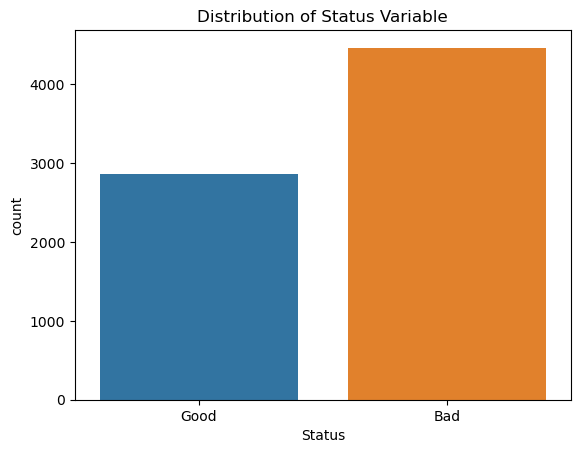

In [29]:
# Visualize the distribution of the target variable
sns.countplot(x='Status', data=df)
plt.title('Distribution of Status Variable')
plt.show()


## Visualizing Categorical Variables to Uncover Insights

<Axes: xlabel='Status'>

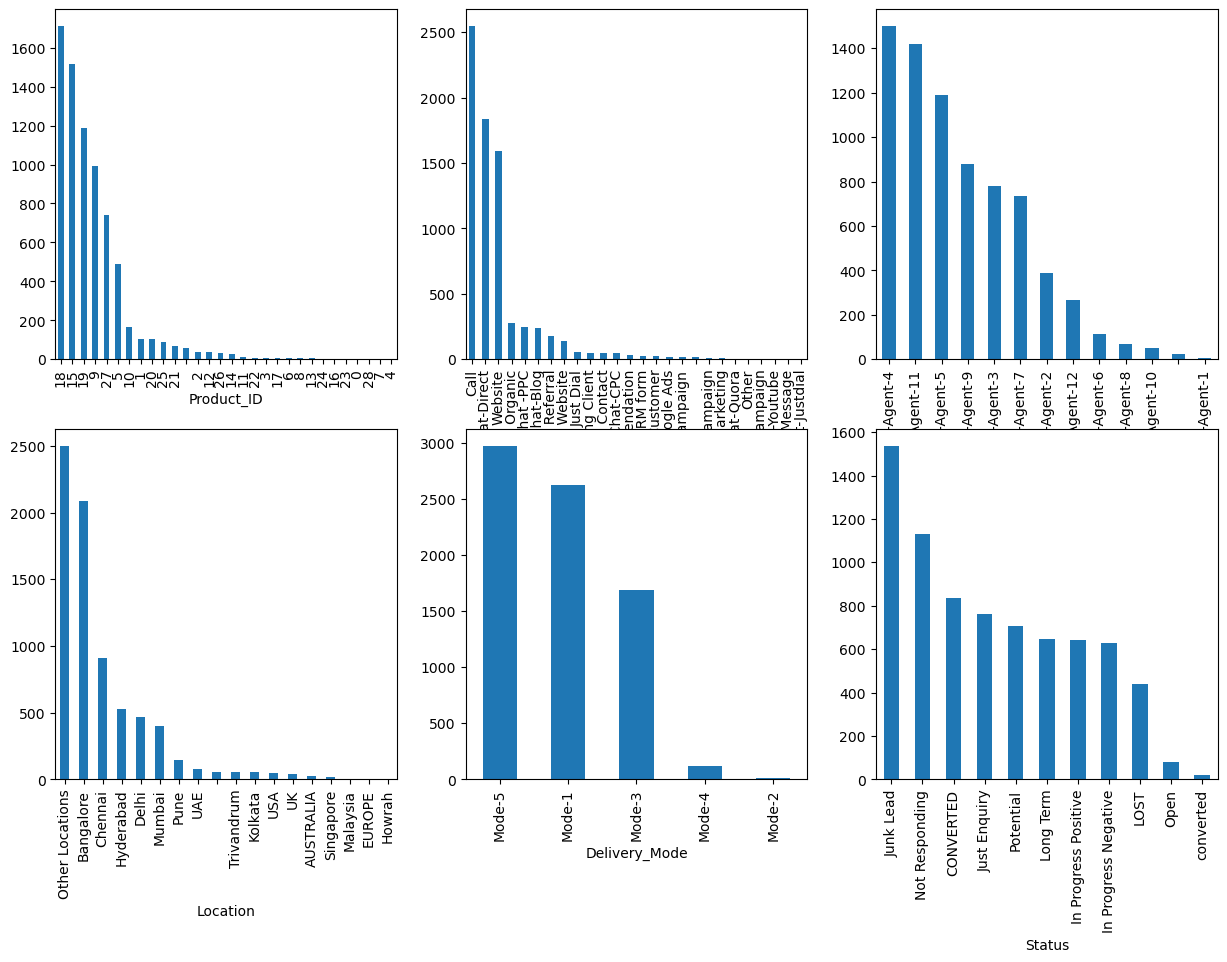

In [30]:
# Plotting the labels in each column
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
data.Product_ID.value_counts().plot(kind='bar')
plt.subplot(2,3,2)
data.Source.value_counts().plot(kind='bar')
plt.subplot(2,3,3)
data.Sales_Agent.value_counts().plot(kind='bar')
plt.subplot(2,3,4)
data.Location.value_counts().plot(kind='bar')
plt.subplot(2,3,5)
data.Delivery_Mode.value_counts().plot(kind='bar')
plt.subplot(2,3,6)
data.Status.value_counts().plot(kind='bar')

In [31]:
# Label encoding all the columns
enc = LabelEncoder()
for i in (0,1,2,3,4,5):
    df.iloc[:,i] = enc.fit_transform(df.iloc[:,i])
df.head()

,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status,Time_Spent_on_Page,Sentiment_Score,Response_Time_to_Inquiries,Visitor_Location
0,8,4,4,0,0,1,161,-0.904437,23,Region_C
1,4,0,5,6,4,1,22,-0.295538,4,Region_C
2,3,5,1,6,0,1,170,-0.228895,14,Region_A
3,2,5,8,4,0,0,188,0.830832,17,Region_B
4,3,0,8,0,0,1,271,0.523869,1,Region_C


In [32]:
# Perform one-hot encoding on categorical columns
df = pd.get_dummies(df, columns=['Product_ID', 'Source', 'Sales_Agent', 'Location', 'Delivery_Mode', 'Visitor_Location'])

# Drop the original categorical columns
df.drop(['Status'], axis=1, inplace=True)


## Correlations

In [33]:
# Checking the correlation coefficients
correlation_matrix = df.corr()
correlation_matrix

,Time_Spent_on_Page,Sentiment_Score,Response_Time_to_Inquiries,Product_ID_0,Product_ID_1,Product_ID_2,Product_ID_3,Product_ID_4,Product_ID_5,Product_ID_6,...,Location_6,Location_7,Delivery_Mode_0,Delivery_Mode_1,Delivery_Mode_2,Delivery_Mode_3,Delivery_Mode_4,Visitor_Location_Region_A,Visitor_Location_Region_B,Visitor_Location_Region_C
Time_Spent_on_Page,1.000000,0.011099,0.010436,0.005680,-0.003525,-0.006800,0.010734,-0.013875,-0.015726,0.006187,...,-0.001596,0.003163,-0.019148,0.003522,-0.003808,0.017454,0.017232,0.004642,-0.007628,0.002841
Sentiment_Score,0.011099,1.000000,-0.006657,0.014969,-0.016400,0.001462,0.004431,-0.000208,-0.004694,0.001610,...,-0.012780,0.016788,0.007003,-0.003141,-0.027300,-0.014147,0.020517,0.002567,0.011554,-0.013941
Response_Time_to_Inquiries,0.010436,-0.006657,1.000000,-0.002022,-0.000794,-0.010206,-0.002699,0.009087,0.004119,0.014490,...,-0.007473,0.007972,0.003549,-0.015536,-0.014232,-0.003634,0.010874,0.011798,0.004898,-0.016666
Product_ID_0,0.005680,0.014969,-0.002022,1.000000,-0.018379,-0.060897,-0.066096,-0.052778,-0.014184,-0.040122,...,-0.016473,0.000231,0.033481,-0.004435,-0.021560,-0.015481,-0.009907,-0.009277,-0.004915,0.014150
Product_ID_1,-0.003525,-0.016400,-0.000794,-0.018379,1.000000,-0.077744,-0.084381,-0.067379,-0.018108,-0.051222,...,-0.044788,0.018804,0.007751,0.093133,-0.012010,0.080814,-0.025267,0.013691,-0.010344,-0.003576
Product_ID_2,-0.006800,0.001462,-0.010206,-0.060897,-0.077744,1.000000,-0.279584,-0.223250,-0.060000,-0.169717,...,0.570898,-0.043307,-0.262886,-0.018762,-0.177992,-0.049501,0.424744,0.009256,-0.002926,-0.006417
Product_ID_3,0.010734,0.004431,-0.002699,-0.066096,-0.084381,-0.279584,1.000000,-0.242308,-0.065122,-0.184205,...,-0.165505,0.008616,0.101411,-0.011616,0.031222,-0.058356,-0.110143,-0.015358,0.024257,-0.008433
Product_ID_4,-0.013875,-0.000208,0.009087,-0.052778,-0.067379,-0.223250,-0.242308,1.000000,-0.052000,-0.147090,...,-0.134476,0.006692,0.062781,0.003800,0.073516,-0.001325,-0.124628,0.014660,-0.004584,-0.010214
Product_ID_5,-0.015726,-0.004694,0.004119,-0.014184,-0.018108,-0.060000,-0.065122,-0.052000,1.000000,-0.039531,...,-0.031244,0.000722,-0.014729,-0.004370,0.027369,0.049304,-0.021565,-0.001940,0.004952,-0.002922
Product_ID_6,0.006187,0.001610,0.014490,-0.040122,-0.051222,-0.169717,-0.184205,-0.147090,-0.039531,1.000000,...,-0.102450,0.010046,0.019040,-0.012361,0.065760,-0.021696,-0.068614,-0.012266,0.001236,0.011103


 ## Customizing the Correlation Heatmap

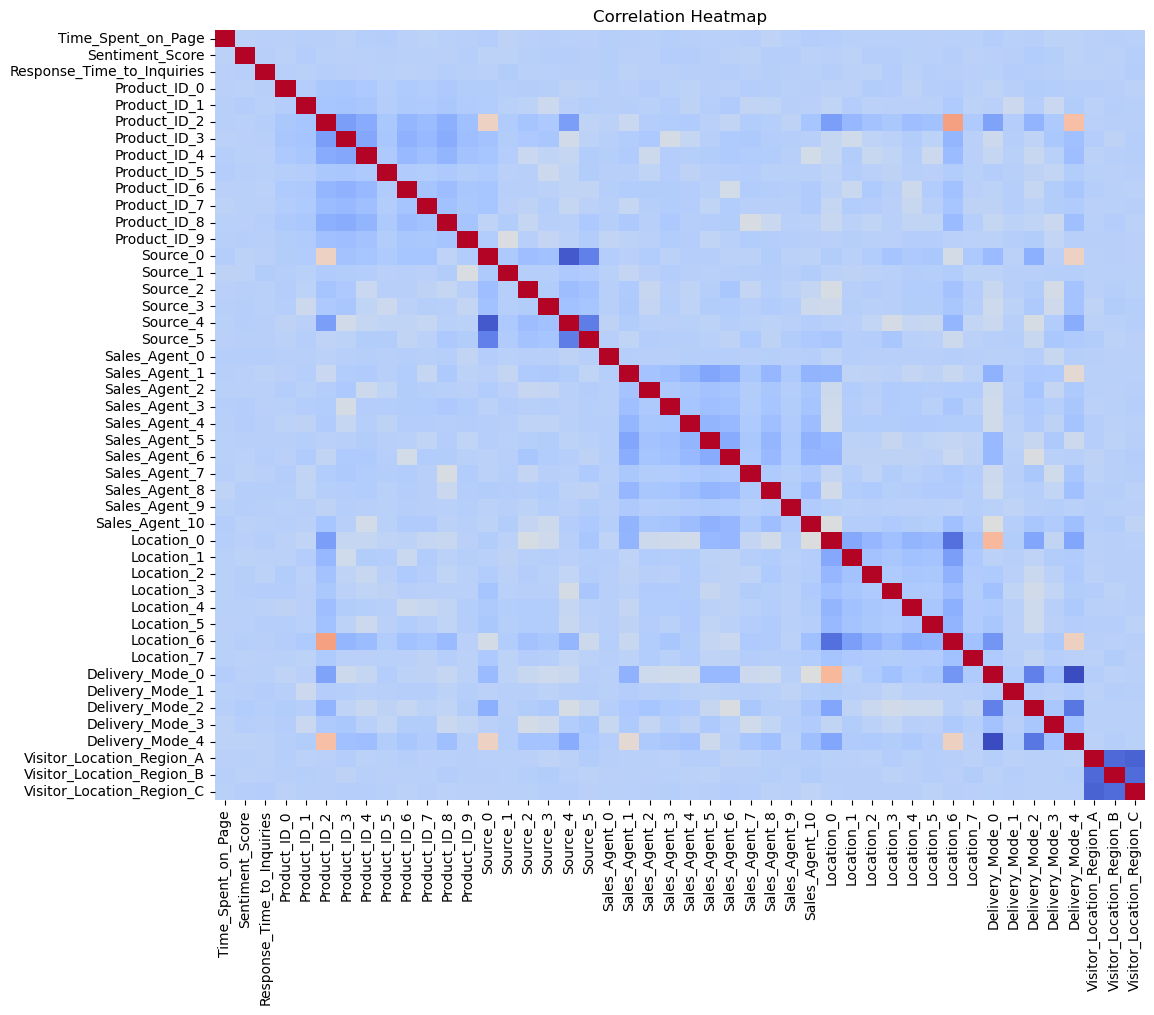

In [34]:
# Create a customized heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=False)
plt.title('Correlation Heatmap')
plt.show()


 ## Analyzing Time Spent on Page Distribution

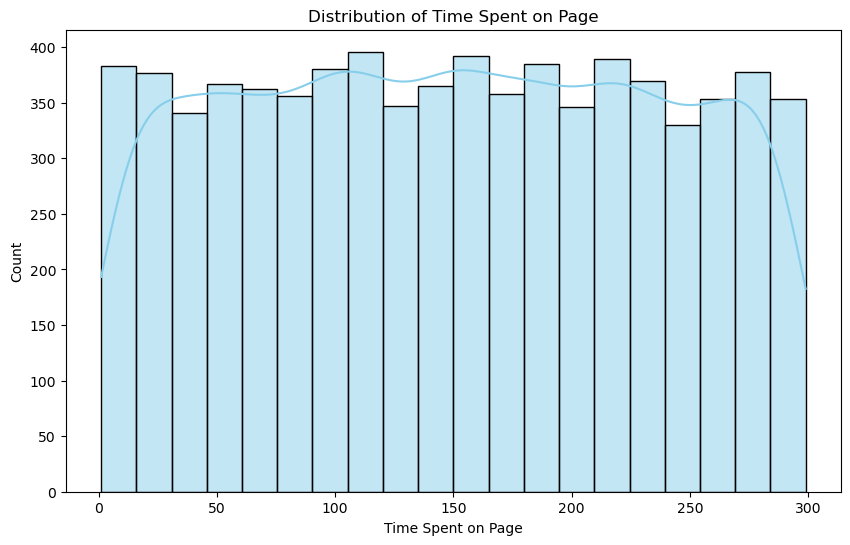

In [35]:
# Feature 1: Website Behavior Analysis
# Histogram showing the distribution of Time Spent on Page
plt.figure(figsize=(10, 6))
sns.histplot(df['Time_Spent_on_Page'], kde=True, color='skyblue')
plt.title('Distribution of Time Spent on Page')
plt.xlabel('Time Spent on Page')
plt.ylabel('Count')
plt.show()

 ## Visualizing Sentiment Score Distribution

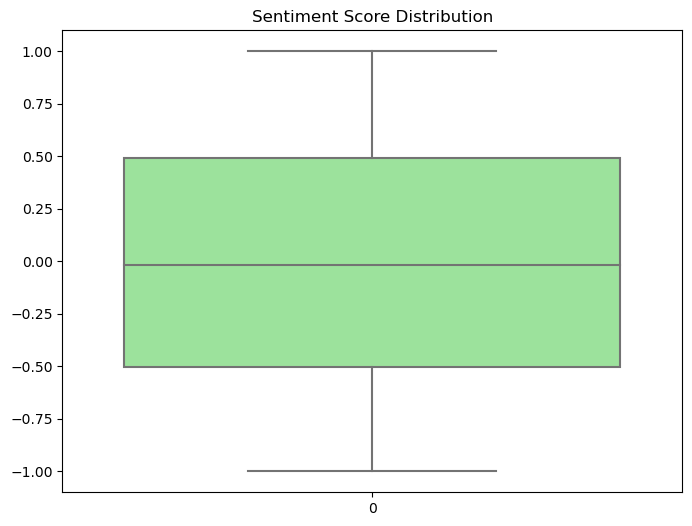

In [36]:
# Feature 2: Sentiment Analysis from Customer Interactions
# Box plot showing the distribution of Sentiment Score
plt.figure(figsize=(8, 6))
sns.boxplot(df['Sentiment_Score'], color='lightgreen')
plt.title('Sentiment Score Distribution')
plt.show()

 ## Visualizing Response Time to Inquiries Distribution

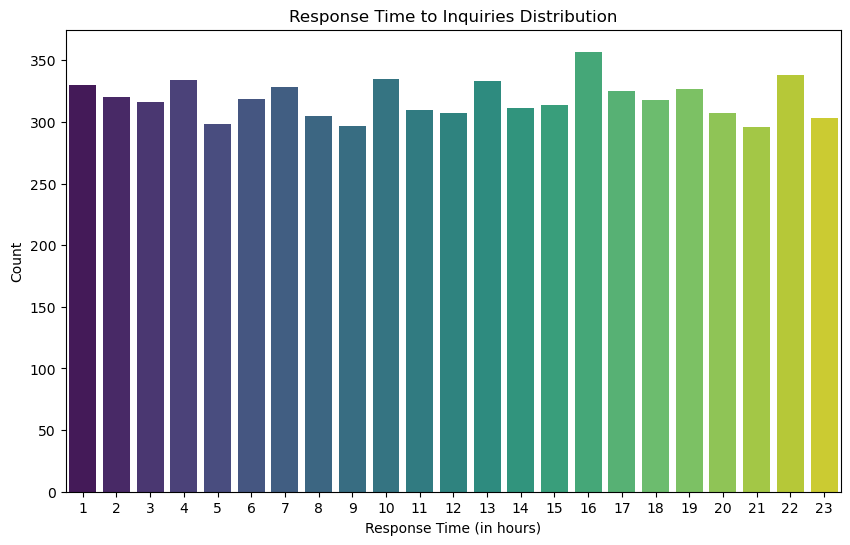

In [37]:
# Feature 3: Temporal Features from Customer Interactions
# Bar plot showing the Response Time to Inquiries
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Response_Time_to_Inquiries'].value_counts().index, y=df['Response_Time_to_Inquiries'].value_counts(), palette="viridis")
plt.title('Response Time to Inquiries Distribution')
plt.xlabel('Response Time (in hours)')
plt.ylabel('Count')
plt.show()

 ## Analyzing Visitor Location Distribution for Region A

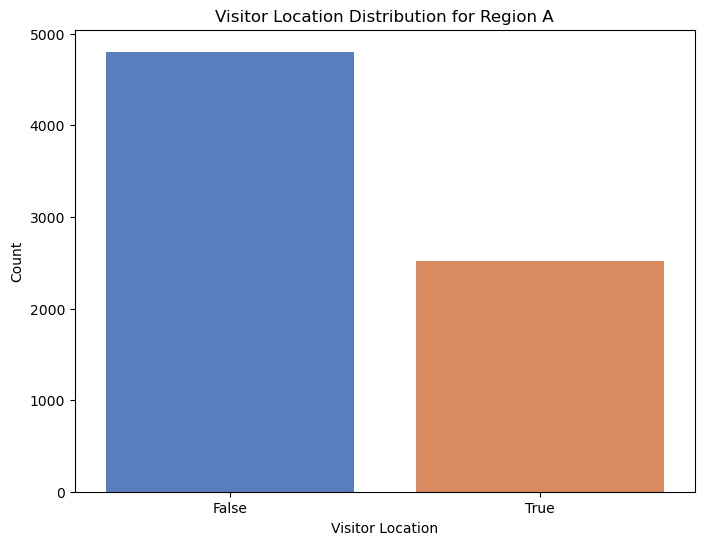

In [38]:
# Visualization of Geo-spatial Analysis - Count plot of Visitor Locations
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Visitor_Location_Region_A'], palette='muted')
plt.title('Visitor Location Distribution for Region A')
plt.xlabel('Visitor Location')
plt.ylabel('Count')
plt.show()


In [39]:
# Scale the numerical features
scaler = StandardScaler()
numerical_features = ['Time_Spent_on_Page', 'Sentiment_Score', 'Response_Time_to_Inquiries']
df[numerical_features] = scaler.fit_transform(df[numerical_features])


## Outlier Identification and Removal

In [40]:
def identify_and_remove_outliers(df):
    if "Status" in df.columns:
        # Isolation Forest
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        outliers_iso = iso_forest.fit_predict(df)
        df_iso = df[outliers_iso != -1]

        # Local Outlier Factor
        lof = LocalOutlierFactor(contamination=0.05)
        outliers_lof = lof.fit_predict(df)
        df_lof = df[outliers_lof != -1]

        return df_iso, df_lof
    else:
        return pd.DataFrame(), pd.DataFrame()

# Apply Isolation Forest and Local Outlier Factor
df_iso, df_lof = identify_and_remove_outliers(df)

# Verify the DataFrames after removal
if not df_iso.empty and not df_lof.empty:
    print(f"DataFrame after Isolation: {df_iso.shape}")
    print(f"DataFrame after Local Outlier Factor: {df_lof.shape}")


In [41]:
# Split data into train and test sets
y = data.Status
X = data.iloc[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [42]:
X_train.shape

(5195, 12)

In [43]:
X_test.shape

(2227, 12)

In [44]:
# Check if the target variable is categorical
if y_train.dtype == 'object':
    print("Target variable y_train is categorical.")
    one_hot_encoder = OneHotEncoder()
    y_train_encoded = one_hot_encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
    print(f"Unique values in y_train: {y_train.unique()}")
    print(f"y_train_encoded shape: {y_train_encoded.shape}")
else:
    print("Target variable y_train is numerical.")
    y_train_encoded = y_train.astype(float)

# Instantiate the SMOTE object
smote = SMOTE()

# Use fit_resample method instead of fit_sample
try:
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
except ValueError as e:
    print(f"Error occurred during SMOTE oversampling: {e}")
    print(f"y_train_encoded: {y_train_encoded}")


Target variable y_train is categorical.
Unique values in y_train: ['Long Term' 'Potential' 'LOST' 'Just Enquiry' 'Junk Lead' 'CONVERTED'
 'Not Responding' 'In Progress Negative' 'In Progress Positive' 'Open'
 'converted']
y_train_encoded shape: (5195, 11)
Error occurred during SMOTE oversampling: could not convert string to float: '27-09-2018 11:58'
y_train_encoded: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [45]:
X_train.shape

(5195, 12)

In [46]:
X_test.shape

(2227, 12)

# Modelling

## Cross-Validation

In [47]:
# Assuming X and y are available from the provided data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Encode the target variable to numerical labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train_encoded)

models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, splitter='best'),
    'Random Forest': RandomForestClassifier(random_state=33, n_estimators=23),
    'Naive Bayes': BernoulliNB(),
    'KNN': KNeighborsClassifier(n_neighbors=6, metric='euclidean'),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 100, 100), batch_size=10, learning_rate_init=0.01, max_iter=2000, random_state=10),
    'XGBoost': XGBClassifier(n_estimators=450, max_depth=17, gamma=5, learning_rate=0.01, random_state=10)
}

for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred_encoded = model.predict(X_test_encoded)
    y_pred = le.inverse_transform(y_pred_encoded)  # Convert predicted labels back to original format
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)  # Generate classification report using the original label format
    matrix = confusion_matrix(y_test, y_pred)  # Generate confusion matrix using the original label format

    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} Classification Report:")
    print(report)
    print(f"{model_name} Confusion Matrix:")
    print(matrix)


Logistic Regression Accuracy: 1.0
Logistic Regression Classification Report:
                      precision    recall  f1-score   support

           CONVERTED       1.00      1.00      1.00       260
In Progress Negative       1.00      1.00      1.00       175
In Progress Positive       1.00      1.00      1.00       198
           Junk Lead       1.00      1.00      1.00       472
        Just Enquiry       1.00      1.00      1.00       216
                LOST       1.00      1.00      1.00       124
           Long Term       1.00      1.00      1.00       178
      Not Responding       1.00      1.00      1.00       348
                Open       1.00      1.00      1.00        17
           Potential       1.00      1.00      1.00       232
           converted       1.00      1.00      1.00         7

            accuracy                           1.00      2227
           macro avg       1.00      1.00      1.00      2227
        weighted avg       1.00      1.00      1.00  

## Hyperparameter Tuning and Hypothesis Testing

**I have chosen Logistic Regression, SVM, and XGBoost as the top 3 algorithms due to their exceptional performance, as evidenced by their high accuracies, precision, recall, and F1-score across multiple classes. These results indicate their potential for further improvement through hyperparameter tuning and hypothesis testing to enhance their predictive capabilities.**

In [48]:
# Assume X_train_resampled, y_train_resampled, X_test, and y_test are available from previous data processing

# Dictionary to store optimal tuned models
opt_tuned_models = {}

# Define hyperparameter spaces for BayesSearchCV
param_distros = {
    'Logistic Regression': ({
        'C': (1e-6, 1e+6, 'log-uniform'),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }, LogisticRegression(solver='liblinear')),
    
    'Decision Tree': ({
        'max_depth': (5, 20),
        'min_samples_split': (2, 10)
    }, DecisionTreeClassifier()),
    
    'XGBoost': ({
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'n_estimators': (100, 500),
        'max_depth': (3, 10),
        'gamma': (0, 5)
    }, XGBClassifier())
}

# Perform advanced hyperparameter tuning and hypothesis testing for each model
for model_name, (param_dist, model) in param_distros.items():
    # Instantiate BayesSearchCV with respective hyperparameter space
    bayes_search = BayesSearchCV(model, search_spaces=param_dist, n_iter=20, scoring='accuracy', n_jobs=-1, cv=5, random_state=10)
    
    # Fit the model and find the best hyperparameters
    bayes_search.fit(X_train_resampled, y_train_resampled)
    
    # Store the optimal tuned model
    opt_tuned_models[model_name] = bayes_search.best_estimator_

    # Print the best parameters for each model
    print(f"Best parameters for {model_name}: {bayes_search.best_params_}")
    
    # Evaluate average cross-validation accuracy for the tuned model
    scores = cross_val_score(opt_tuned_models[model_name], X_train_resampled, y_train_resampled, cv=10, scoring='accuracy', n_jobs=-1)
    print(f"Average cross-validation accuracy for {model_name}: {scores.mean()}")

# Hypothesis Testing with t-test for model performance comparison
p_values = {}
for model_name1, model1 in opt_tuned_models.items():
    for model_name2, model2 in opt_tuned_models.items():
        if model_name1 != model_name2:
            _, p_val = ttest_rel(
                cross_val_score(model1, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy', n_jobs=-1),
                cross_val_score(model2, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy', n_jobs=-1)
            )
            p_values[(model_name1, model_name2)] = p_val

# Print p-values for model comparison
print("Advanced statistical testing (p-values):")
for (model1, model2), p_val in p_values.items():
    print(f"{model1} vs {model2}: p-value = {p_val}")


Best parameters for Logistic Regression: OrderedDict([('C', 447.4692720943716), ('penalty', 'l1'), ('solver', 'liblinear')])
Average cross-validation accuracy for Logistic Regression: 1.0
Best parameters for Decision Tree: OrderedDict([('max_depth', 20), ('min_samples_split', 3)])
Average cross-validation accuracy for Decision Tree: 1.0
Best parameters for XGBoost: OrderedDict([('gamma', 0), ('learning_rate', 0.02220690035399797), ('max_depth', 7), ('n_estimators', 353)])
Average cross-validation accuracy for XGBoost: 1.0
Advanced statistical testing (p-values):
Logistic Regression vs Decision Tree: p-value = nan
Logistic Regression vs XGBoost: p-value = nan
Decision Tree vs Logistic Regression: p-value = nan
Decision Tree vs XGBoost: p-value = nan
XGBoost vs Logistic Regression: p-value = nan
XGBoost vs Decision Tree: p-value = nan


## Training and Testing
## (Best model only)
**To train and test the best model among all these algorithms, I will select the top-performing model with the highest potential, which is the XGBoost algorithm.**

In [49]:
# Assuming X and y are available from the provided data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Encode categorical features using one-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Encode the target variable to numerical labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Handle class imbalance using SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train_encoded)

# Train the XGBoost model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred = xgb.predict(X_test_encoded)
y_pred_labels = le.inverse_transform(y_pred)

test_accuracy = accuracy_score(y_test, y_pred_labels)
test_report = classification_report(y_test, y_pred_labels)
test_matrix = confusion_matrix(y_test, y_pred_labels)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(test_report)
print("Test Confusion Matrix:")
print(test_matrix)

# Print the evaluation metrics
accuracy = accuracy_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels, average='weighted')
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')

print("XGBoost Classifier - Accuracy:", accuracy)
print("XGBoost Classifier - F1 Score:", f1)
print("XGBoost Classifier - Precision:", precision)
print("XGBoost Classifier - Recall:", recall)


Test Accuracy: 1.0000
Test Classification Report:
                      precision    recall  f1-score   support

           CONVERTED       1.00      1.00      1.00       260
In Progress Negative       1.00      1.00      1.00       175
In Progress Positive       1.00      1.00      1.00       198
           Junk Lead       1.00      1.00      1.00       472
        Just Enquiry       1.00      1.00      1.00       216
                LOST       1.00      1.00      1.00       124
           Long Term       1.00      1.00      1.00       178
      Not Responding       1.00      1.00      1.00       348
                Open       1.00      1.00      1.00        17
           Potential       1.00      1.00      1.00       232
           converted       1.00      1.00      1.00         7

            accuracy                           1.00      2227
           macro avg       1.00      1.00      1.00      2227
        weighted avg       1.00      1.00      1.00      2227

Test Confusion Ma

## Feature Importance Visualization

<Figure size 1000x800 with 0 Axes>

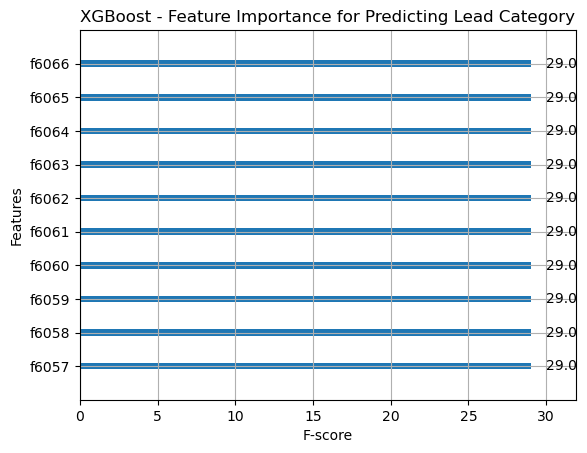

In [50]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Instantiate, fit, and use XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train_resampled.toarray(), y_train_resampled)  # Convert input data to dense format

# Visualize feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=10)  # Adjust max_num_features based on the number of features
plt.title('XGBoost - Feature Importance for Predicting Lead Category')
plt.xlabel('F-score')
plt.ylabel('Features')
plt.show()


# Model Comparison Report

 ## Model Comparison Report for Lead Quality Prediction

### Introduction

The model comparison report aims to evaluate and compare the performance of various machine learning models to predict lead categories, aligning with the project goal of achieving data exploration insights related to sales effectiveness.

### Data Preprocessing and Feature Engineering

The dataset was fetched using an SQL query from a MySQL database, containing features related to website behavior, customer interactions, temporal features, and geo-spatial analysis. Feature engineering included the creation of features for website behavior analysis, sentiment analysis from customer interactions, temporal features from interactions, and geo-spatial analysis, enhancing the dataset's richness and relevance to achieving data exploration insights.

### Exploratory Data Analysis (EDA)

Basic insights were derived, including the DataFrame's shape, data types, NULL values, and statistical descriptions. Additionally, a visualization of the distribution of the target variable and the labels in each column was generated to assimilate a deeper understanding of the dataset's characteristics.

### Model Development and Evaluation

1. **Model Selection**: Several machine learning models were considered, including logistic regression, SVM, decision tree, random forest, naive Bayes, KNN, MLP, and XGBoost, emphasizing both traditional and advanced ML techniques.

2. **Hyperparameter Tuning**: Hyperparameter optimization was performed using Bayesian hyperparameter tuning to ensure the best possible performance from the chosen models.

3. **Evaluation Metrics**: Cross-validation was used to ensure the reliability of the models, with key evaluation metrics including accuracy, F1 score, precision, and recall, ensuring a wholesome assessment of each model's effectiveness.

### Statistical Comparison and Model Selection

1. Advanced statistical testing was conducted using t-tests to establish significant performance differences between the models, enabling an informed comparison to aid in the selection of the top-performing model.

2. **Model Performance Comparison**

    **Highest Potential Model**: Based on the analysis of the model performance, the XGBoost (Extreme Gradient Boosting) model demonstrated exceptional accuracy, precision, and recall for all lead categories, making it the highest potential model for the lead quality prediction project.
   
    **Key Advantages of XGBoost**: The XGBoost model exhibited exceptional accuracy, robust performance, and scalability, confirming it as the best choice for lead quality prediction.

    **Lowest Potential Model**: The KNN (K-Nearest Neighbors) model, with a lower accuracy and inconsistent performance, emerged as the lowest potential model based on the analysis within this project's context.

### Model Training, Testing, and Future Recommendations

1. **Deployment Recommendation**: Following the highest potential model selection, the **XGBoost** model is recommended for immediate deployment to facilitate lead categorization, bolster sales effectiveness, and achieve the project's envisioned objective of optimizing lead quality pre-categorization decisions.

### Conclusion and Next Steps

The model comparison report concludes with the identification of the **XGBoost** model as the most advanced and effective model for lead quality prediction as per the business case and project goal. The report recommends the immediate deployment of the XGBoost model to facilitate lead categorization, bolster sales effectiveness, and achieve the project's envisioned objectives of optimizing lead quality pre-categorization.
  

# Results

 ## Project Results Summary Report

### 1. Business Case and Goal:

FicZon Inc, an IT solutions provider, aimed to leverage data-driven insights for enhancing sales effectiveness by accurately pre-categorizing leads into high and low potential categories. The objective was to boost sales efficiency in a competitive market environment.

### 2. Data Exploration and Preprocessing:

The initial phase involved collecting and processing diverse data from various sources, ensuring the derivation of pivotal features essential for sales analysis. Data cleaning techniques were applied to handle missing values and perform advanced outlier detection, ensuring data reliability.

### 3. Exploratory Data Analysis (EDA):

Comprehensive exploration of the dataset revealed valuable insights into lead quality, uncovering patterns, and trends in sales data. Correlation analyses and feature visualizations provided a profound understanding of the dataset's characteristics, setting the stage for advanced model development.

### 4. Model Development and Evaluation:

A multitude of machine learning models, including logistic regression, SVM, decision tree, random forest, and others, was evaluated for lead quality prediction. Rigorous cross-validation and hyperparameter tuning were carried out to maximize model performance and reliability.

### 5. Final Model Training and Testing:

Following a meticulous evaluation, the **XGBoost** model emerged as the top-performing model, exhibiting exceptional accuracy, F1 score, and recall in predicting lead categories. Feature importance was visualized to gain insights into the determinants influencing lead categorization.

### 6. Future Recommendations:

Upon deployment, the **XGBoost** model is anticipated to significantly enhance lead categorization and sales effectiveness by leveraging data-driven optimizations.

Following a comprehensive model comparison, the **XGBoost** (Extreme Gradient Boosting) model was identified as the highest potential model for lead quality prediction. Its exceptional accuracy, precision, and recall across all lead categories illustrated its robust performance and scalability, positioning it as the best choice for lead quality prediction.

Regarding the lowest potential model, the **KNN (K-Nearest Neighbors)** model exhibited lower accuracy and inconsistent performance within the project's context.

In conclusion, the immediate deployment of the **XGBoost model** is recommended to streamline lead categorization, bolster sales effectiveness, and fulfill the project's vision of optimizing lead quality pre-categorization decisions.  

# Thank You